In [312]:
from multiprocessing.pool import ThreadPool
import numpy as np
import pandas as pd
import sktime
from sktime.datasets import load_from_tsfile
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, precision_score, recall_score)
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
import xgboost as xgb
import optuna
import progressbar
import plotly.graph_objects as go

### Replicating results from [paper](https://link.springer.com/article/10.1007/s10618-020-00727-3)

In [12]:
!ls data

AtrialFibrillation
Epilepsy
FaceDetection
Heartbeat


In [13]:
!ls data/Epilepsy

Epilepsy.jpg
Epilepsy.txt
Epilepsy_TEST.arff
Epilepsy_TEST.ts
Epilepsy_TRAIN.arff
Epilepsy_TRAIN.ts
EpilepsyDimension1_TEST.arff
EpilepsyDimension1_TRAIN.arff
EpilepsyDimension2_TEST.arff
EpilepsyDimension2_TRAIN.arff
EpilepsyDimension3_TEST.arff
EpilepsyDimension3_TRAIN.arff


In [14]:
X_train, y_train = load_from_tsfile('data/Epilepsy/Epilepsy_TRAIN.ts')
len(X_train), len(y_train)

(137, 137)

In [15]:
X_train.iloc[0, 0]

0      0.35
1      0.40
2      0.44
3      0.47
4      0.48
       ... 
201    0.58
202    0.61
203    0.62
204    0.65
205    0.69
Length: 206, dtype: float64

In [16]:
X_train

,dim_0,dim_1,dim_2
0,0 0.35 1 0.40 2 0.44 3 0.4...,0 0.22 1 0.01 2 -0.71 3 -0.3...,0 0.55 1 0.51 2 0.52 3 0.4...
1,0 -0.91 1 -0.92 2 -0.95 3 -0.9...,0 -0.05 1 -0.02 2 0.01 3 0.0...,0 0.06 1 -1.57 2 -0.99 3 0.2...
2,0 0.32 1 0.71 2 0.70 3 0.7...,0 1.00 1 -1.33 2 -1.44 3 -0.1...,0 0.37 1 0.37 2 0.37 3 0.3...
3,0 -0.68 1 -0.36 2 -0.13 3 -0.3...,0 -1.69 1 -0.58 2 1.05 3 -0.1...,0 0.31 1 0.31 2 0.32 3 0.0...
4,0 0.34 1 0.53 2 0.58 3 0.6...,0 -0.89 1 1.17 2 1.00 3 -1.8...,0 0.45 1 -0.05 2 -0.17 3 -0.4...
...,...,...,...
132,0 0.45 1 -0.28 2 0.28 3 1.3...,0 -0.21 1 -1.20 2 -1.26 3 -0.4...,0 -0.58 1 -0.87 2 -0.38 3 -0.0...
133,0 0.24 1 -0.79 2 -0.65 3 0.0...,0 0.50 1 0.69 2 0.86 3 0.6...,0 -0.99 1 -0.99 2 -0.65 3 -0.4...
134,0 1.16 1 -0.02 2 -1.04 3 -0.8...,0 0.90 1 0.59 2 0.52 3 0.2...,0 -1.03 1 -1.11 2 -0.88 3 -0.9...
135,0 -0.74 1 -0.14 2 0.12 3 -0.0...,0 -0.19 1 -0.24 2 -0.34 3 -0.6...,0 -0.14 1 -0.26 2 -0.27 3 -0.3...


In [17]:
X_test, y_test = load_from_tsfile('data/Epilepsy/Epilepsy_TEST.ts')
len(X_test), len(y_test)

(138, 138)

In [18]:
rocket = Rocket()

In [19]:
%%time
rocket.fit(X_train)

CPU times: total: 1.22 s
Wall time: 1.19 s


Rocket()

In [20]:
%%time
X_train_transform = rocket.transform(X_train)

CPU times: total: 7.75 s
Wall time: 7.42 s


In [21]:
X_train_transform

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.359223,8.142284,0.330097,2.042992,0.679612,5.203921,0.572816,7.317623,0.402913,5.379340,...,0.393204,2.880233,0.538835,9.702896,0.664179,6.941274,0.192308,1.953574,0.697368,6.043885
1,0.286408,3.784554,0.402913,3.232322,0.830097,3.803563,0.766990,5.227424,0.252427,4.625084,...,0.305825,3.086771,0.519417,7.480976,0.656716,5.286521,0.461538,10.231942,0.552632,5.535629
2,0.475728,8.694588,0.461165,1.970298,0.699029,6.183525,0.563107,10.348371,0.330097,2.700500,...,0.398058,6.803451,0.558252,11.111014,0.731343,10.406590,0.230769,5.568315,0.657895,6.103149
3,0.242718,13.551611,0.271845,2.663503,0.640777,6.037632,0.572816,7.831147,0.266990,6.863508,...,0.398058,4.052872,0.592233,13.776570,0.552239,9.145141,0.269231,2.112035,0.618421,4.762105
4,0.456311,8.556611,0.417476,2.259567,0.752427,4.247398,0.635922,7.368914,0.257282,1.426416,...,0.271845,3.962652,0.538835,7.909561,0.597015,5.583895,0.230769,4.924429,0.921053,2.527858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.436893,9.506288,0.436893,2.275921,0.713592,4.396750,0.543689,7.083404,0.174757,1.385363,...,0.461165,4.055876,0.504854,8.137795,0.619403,6.463929,0.500000,6.241920,0.552632,6.168213
133,0.320388,5.664809,0.432039,2.558356,0.699029,7.872572,0.616505,8.255204,0.393204,7.362336,...,0.271845,3.661802,0.621359,8.984266,0.664179,5.551358,0.384615,4.703537,0.618421,7.518395
134,0.310680,5.811820,0.296117,1.592473,0.650485,4.212702,0.616505,5.438809,0.364078,8.111129,...,0.150485,1.239111,0.509709,10.961086,0.858209,3.874510,0.576923,5.173196,0.789474,5.627006
135,0.402913,7.363855,0.441748,2.425854,0.538835,7.950586,0.592233,5.734698,0.514563,9.045206,...,0.461165,2.721397,0.543689,6.991741,0.641791,5.181992,0.423077,3.338155,0.618421,5.587883


In [22]:
classifier = RidgeClassifier()

In [23]:
classifier.fit(X_train_transform, y_train)

RidgeClassifier()

In [24]:
classifier.score(X_train_transform, y_train)

1.0

In [25]:
X_test_transform = rocket.transform(X_test)

In [26]:
def print_cv_metrics(classifier, X_test, y_test, _round=False, print_results=True):
    y_pred = classifier.predict(X_test)
    if _round:
        y_pred = y_pred.round()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    if print_results:
        print(f'{classifier} ->')
        print(f'Accuracy: {acc:.4f}')
        print(f'Precision: {prec:.4f}')
        print(f'recall: {rec:.4f}')
        print(f'F1: {f1:.4f}\n')
        display(ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot())

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

In [166]:
def print_cv_metrics_for_pred(y_test, y_pred, print_results=True):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    if print_results:
        print(f'Accuracy: {acc:.4f}')
        print(f'Precision: {prec:.4f}')
        print(f'recall: {rec:.4f}')
        print(f'F1: {f1:.4f}\n')
        display(ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot())

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

In [27]:
res_df = pd.DataFrame()

RidgeClassifier() ->
Accuracy: 0.9710
Precision: 0.9725
recall: 0.9710
F1: 0.9710



C:\Users\Lucas\AppData\Local\Temp\ipykernel_6828\3476185369.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(classifier, X_test_transform, y_test), index=['ridge on rocket']))


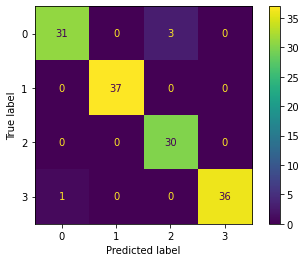

In [28]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(classifier, X_test_transform, y_test), index=['ridge on rocket']))

In [29]:
label_encoder = {label: i for i, label in enumerate(set(y_train))}
label_decoder = {i: label for label, i in label_encoder.items()}
label_encoder, label_decoder

({'sawing': 0, 'walking': 1, 'running': 2, 'epilepsy': 3},
 {0: 'sawing', 1: 'walking', 2: 'running', 3: 'epilepsy'})

#### Testing XGB on rocket transformed X

In [30]:
encoded_y_train = [label_encoder[label] for label in y_train]

In [109]:
dtrain = xgb.DMatrix(X_train_transform, encoded_y_train)

In [32]:
booster = xgb.train({}, dtrain)

In [33]:
booster

In [34]:
encoded_y_test = [label_encoder[label] for label in y_test]

In [111]:
dxtest = xgb.DMatrix(X_test_transform)

<xgboost.core.Booster object at 0x0000019AA8910CA0> ->
Accuracy: 0.7319
Precision: 0.8057
recall: 0.7319
F1: 0.7409



C:\Users\Lucas\AppData\Local\Temp\ipykernel_6828\152857220.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(booster, dxtest, encoded_y_test, _round=True), index=['xgb on rocket']))


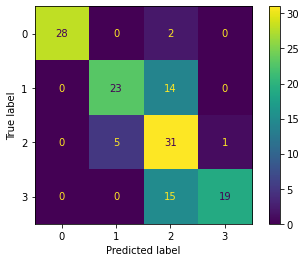

In [36]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(booster, dxtest, encoded_y_test, _round=True), index=['xgb on rocket']))

In [37]:
res_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1
ridge on rocket,0.971014,0.972538,0.971014,0.971043
xgb on rocket,0.731884,0.805745,0.731884,0.740926


#### Trying to optimize xgb

In [88]:
def splits(X_train, y_train, n=5):
    splits = []
    for train_index, test_index in StratifiedKFold(n_splits=n).split(X_train, y_train):
        _X_train, _X_test = X_train.loc[train_index], X_train.loc[test_index]
        _y_train, _y_test = y_train[train_index], y_train[test_index]
        _X_train['y'] = _y_train
        _X_test['y'] = _y_test
        _train = resample(_X_train)
        _test = resample(_X_test)
        _y_train = _train.pop('y')
        _y_test = _test.pop('y')
        splits.append((_train, _y_train, _test, _y_test))
    return splits

In [89]:
# saving splits to make it faster
train_splits = splits(X_train_transform, np.array(encoded_y_train))

In [91]:
dtrain_splits = [(xgb.DMatrix(split[0], split[1]), xgb.DMatrix(split[2], split[3])) for split in train_splits]

In [93]:
def xgb_kfold_gen():
    for i, split in enumerate(dtrain_splits):
        dtrain = split[0]
        dvalid = split[1]
        y_val = train_splits[i][3]
        yield dtrain, dvalid, y_val

In [161]:
def objective(trial):
    param = {
        'eval_metric': 'auc',
        'objective': 'multi:softprob',
        'num_class': 4,
        'verbosity': 0,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('min_child_weight', 1e-1, 10)
    }
    scores = []
    for dtrain, dvalid, y_val in xgb_kfold_gen():
        pruner = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')
        booster = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], callbacks=[pruner], verbose_eval=False)
        y_pred = [i.argmax() for i in booster.predict(dvalid)]
        scores.append(accuracy_score(y_val, y_pred))
    
    return np.mean(scores)

In [142]:
def optimize_params():
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=30, n_warmup_steps=30, interval_steps=10
        )
    )
    study.optimize(objective, n_trials=300)
    return study.best_params

In [162]:
params = optimize_params()
params

[I 2022-06-05 10:56:32,133] A new study created in memory with name: no-name-54d46792-c09b-4697-9e70-aede57ff1c00
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 10:58:12,240] Trial 11 finished with value: 0.9563492063492063 and parameters: {'booster': 'gblinear', 'lambda': 5.394089832734193e-06, 'alpha': 0.0011714647885522347, 'learning_rate': 0.013060607730090976, 'gamma': 84.55019190420622, 'n_estimators': 396, 'max_depth': 1, 'min_child_weight': 1.1118553833381246}. Best is trial 5 with value: 0.9711640211640212.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then o

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 10:59:59,492] Trial 24 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 2.464317797630054e-05, 'alpha': 7.139195179764552e-08, 'learning_rate': 0.17820138051909765, 'gamma': 3.1116625894969414, 'n_estimators': 429, 'max_depth': 1, 'min_child_weight'

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:01:45,590] Trial 37 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 1.641467213885373e-05, 'alpha': 2.7938518549481385e-08, 'learning_rate': 0.10621964420779369, 'gamma': 0.6399610285224833, 'n_estimators': 862, 'max_depth': 4, 'min_child_weight

[I 2022-06-05 11:01:54,057] Trial 38 finished with value: 0.8116402116402115 and parameters: {'booster': 'gbtree', 'lambda': 2.6412091863993996e-06, 'alpha': 3.385639980245707e-08, 'learning_rate': 0.1746738726691163, 'gamma': 0.26458904763822977, 'n_estimators': 889, 'max_depth': 5, 'min_child_weight': 0.576129137860039}. Best is trial 5 with value: 0.9711640211640212.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reporte

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:03:29,629] Trial 51 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 0.0001297842035821502, 'alpha': 2.601735771857557e-08, 'learning_rate': 0.10821547356691763, 'gamma': 1.072350722528353, 'n_estimators': 201, 'max_depth': 8, 'min_child_weight': 1.31310426018958}. Best is trial 5 with value: 0.9711640211640212.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:05:08,515] Trial 64 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 4.963076588753374e-05, 'alpha': 2.1631776775405117e-07, 'learning_rate': 0.28649797335308796, 'gamma': 250.782500355092, 'n_estimators': 113, 'max_depth': 8, 'min_child_weight':

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:06:40,777] Trial 76 finished with value: 0.9563492063492063 and parameters: {'booster': 'gblinear', 'lambda': 1.747878036187459e-05, 'alpha': 1.0547808826610923e-08, 'learning_rate': 0.03976956666736829, 'gamma': 0.08842073851828199, 'n_estimators': 850, 'max_depth': 4, 'min_child_weigh

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:08:19,248] Trial 89 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 8.90624819750544e-05, 'alpha': 1.0360757188706911e-05, 'learning_rate': 0.030990590093493604, 'gamma': 116.01899723374495, 'n_estimators': 811, 'max_depth': 7, 'min_child_weight

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:09:50,554] Trial 101 finished with value: 0.9563492063492063 and parameters: {'booster': 'gblinear', 'lambda': 2.482050807398081e-07, 'alpha': 1.9065722145937788e-07, 'learning_rate': 0.3769427474839023, 'gamma': 285.60784622938183, 'n_estimators': 102, 'max_depth': 4, 'min_child_weight

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:11:13,962] Trial 113 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 1.778227634941169e-08, 'alpha': 1.1494261452253066e-06, 'learning_rate': 0.33681001695199947, 'gamma': 3.510439618394374, 'n_estimators': 49, 'max_depth': 10, 'min_child_weight

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:12:37,611] Trial 125 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 2.6444387059327463e-05, 'alpha': 1.9095583246864134e-07, 'learning_rate': 0.28611841704159036, 'gamma': 1.5475113612224334, 'n_estimators': 796, 'max_depth': 5, 'min_child_weig

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:12:52,375] Trial 126 finished with value: 0.8116402116402117 and parameters: {'booster': 'dart', 'lambda': 9.129941613544184e-08, 'alpha': 1.6504337771803708e-07, 'learning_rate': 0.2834606210062896, 'gamma': 1.5378455799031234, 'n_estimators': 770, 'max_depth': 2, 'min_child_weight': 1.663085594665054}. Best is trial 5 with value: 0.9711640211640212.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:14:14,813] Trial 138 finished with value: 0.825925925925926 and parameters: {'booster': 'gbtree', 'lambda': 1.4208032285941512e-08, 'alpha': 1.9322317468838014e-06, 'learning_rate': 0.02441991760635236, 'gamma': 0.0002635043577785218, 'n_estimators': 182, 'max_depth': 7, 'min_child_weig

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:15:45,247] Trial 150 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 4.291518308013454e-06, 'alpha': 1.2220302707960767e-07, 'learning_rate': 0.2860117789103539, 'gamma': 487.37020445381796, 'n_estimators': 994, 'max_depth': 1, 'min_child_weight

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:17:08,781] Trial 162 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 2.1267843714195287e-07, 'alpha': 7.382793516858032e-07, 'learning_rate': 0.3863979630293002, 'gamma': 0.0003998558425437155, 'n_estimators': 94, 'max_depth': 2, 'min_child_weig

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:18:31,361] Trial 174 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 1.5638357576708148e-08, 'alpha': 1.1109083626805834e-06, 'learning_rate': 0.3410882492265405, 'gamma': 0.0005314687323639528, 'n_estimators': 30, 'max_depth': 1, 'min_child_wei

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:18:37,186] Trial 175 finished with value: 0.9637566137566136 and parameters: {'booster': 'gblinear', 'lambda': 3.632103633112965e-08, 'alpha': 0.010646968684526697, 'learning_rate': 0.41139672934380545, 'gamma': 0.0005554205151878366, 'n_estimators': 90, 'max_depth': 1, 'min_child_weight': 5.637255030791881}. Best is trial 5 with value: 0.9711640211640212.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:20:14,246] Trial 188 finished with value: 0.9637566137566136 and parameters: {'booster': 'gblinear', 'lambda': 1.502545273345371e-06, 'alpha': 3.0518727488976103e-06, 'learning_rate': 0.3923916833460342, 'gamma': 51.28780619076604, 'n_estimators': 71, 'max_depth': 1, 'min_child_weight':

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:21:37,718] Trial 200 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 1.0158197450324655e-08, 'alpha': 1.0662081725099692e-06, 'learning_rate': 0.41083118799318885, 'gamma': 7.926283971742555e-05, 'n_estimators': 36, 'max_depth': 1, 'min_child_we

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:23:01,489] Trial 212 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 9.375336470559602e-07, 'alpha': 6.77610853206018e-07, 'learning_rate': 0.3225987368072038, 'gamma': 82.43009633065766, 'n_estimators': 958, 'max_depth': 10, 'min_child_weight':

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:24:25,039] Trial 224 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 2.0146433161639024e-07, 'alpha': 6.910513576147561e-07, 'learning_rate': 0.32304297452690844, 'gamma': 5.8023197816427074e-05, 'n_estimators': 950, 'max_depth': 9, 'min_child_w

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:25:57,014] Trial 236 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 2.9809880985535623e-07, 'alpha': 1.040350663710365e-06, 'learning_rate': 0.28399026458033644, 'gamma': 92.46645270452841, 'n_estimators': 959, 'max_depth': 10, 'min_child_weigh

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:27:20,424] Trial 248 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 1.703730356936162e-07, 'alpha': 1.4131548051469805e-06, 'learning_rate': 0.26898114112296023, 'gamma': 4.9480598120553134e-05, 'n_estimators': 925, 'max_depth': 10, 'min_child_

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:28:43,865] Trial 260 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 2.1868089188517812e-07, 'alpha': 5.837129276041026e-07, 'learning_rate': 0.32233233767922276, 'gamma': 201.27115157035712, 'n_estimators': 908, 'max_depth': 10, 'min_child_weig

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:30:14,719] Trial 272 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 4.076447831541134e-07, 'alpha': 1.059323085658906e-06, 'learning_rate': 0.38769284554702466, 'gamma': 228.51044021007593, 'n_estimators': 960, 'max_depth': 10, 'min_child_weigh

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:31:38,436] Trial 284 finished with value: 0.9637566137566138 and parameters: {'booster': 'gblinear', 'lambda': 2.0960998714844466e-07, 'alpha': 3.081193135041198e-07, 'learning_rate': 0.3412305371012525, 'gamma': 304.71789980427087, 'n_estimators': 933, 'max_depth': 9, 'min_child_weight

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
[I 2022-06-05 11:33:10,806] Trial 296 finished with value: 0.9711640211640212 and parameters: {'booster': 'gblinear', 'lambda': 4.5072037793926604e-07, 'alpha': 5.167633671871461e-07, 'learning_rate': 0.2796720239731612, 'gamma': 3.2161967490226055e-05, 'n_estimators': 961, 'max_depth': 10, 'min_child_w

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Us

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

{'booster': 'gblinear',
 'lambda': 7.097252210609357e-07,
 'alpha': 9.593004293578041e-07,
 'learning_rate': 0.46643857484952844,
 'gamma': 5.5258410084573075e-05,
 'n_estimators': 274,
 'max_depth': 9,
 'min_child_weight': 4.62635979386976}

In [172]:
params['eval_metric'] = 'auc'
params['objective'] = 'multi:softprob'
params['num_class'] = 4

In [173]:
params

{'booster': 'gblinear',
 'lambda': 7.097252210609357e-07,
 'alpha': 9.593004293578041e-07,
 'learning_rate': 0.46643857484952844,
 'gamma': 5.5258410084573075e-05,
 'n_estimators': 274,
 'max_depth': 9,
 'min_child_weight': 4.62635979386976,
 'eval_metric': 'auc',
 'objective': 'multi:softprob',
 'num_class': 4}

In [174]:
booster = xgb.train(params, dtrain)
booster

Accuracy: 0.9493
Precision: 0.9530
recall: 0.9493
F1: 0.9489



C:\Users\Lucas\AppData\Local\Temp\ipykernel_6828\2537572635.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics_for_pred(encoded_y_test, [i.argmax() for i in booster.predict(dxtest)]), index=['optuna xgb on rocket']))


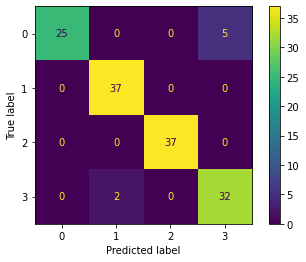

In [177]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics_for_pred(encoded_y_test, [i.argmax() for i in booster.predict(dxtest)]), index=['optuna xgb on rocket']))

In [178]:
res_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1
ridge on rocket,0.971014,0.972538,0.971014,0.971043
optuna xgb on rocket,0.949275,0.952956,0.949275,0.948891
xgb on rocket,0.731884,0.805745,0.731884,0.740926


### 30 trials with resample and average accuracy

In [258]:
class RidgeRocket:
    def __init__(self, verbose=False):
        self.rocket = Rocket()
        self.classifier = RidgeClassifier()
        self.verbose = verbose

    def fit(self, X_train, y_train):
        self.rocket.fit(X_train)
        X_train_transform = self.rocket.transform(X_train)
        self.classifier.fit(X_train_transform, y_train)
        if self.verbose:
            print('train score:', self.classifier.score(X_train_transform, y_train))

    def predict(self, X_test):
        X_test_transform = self.rocket.transform(X_test)
        return self.classifier.predict(X_test_transform)

    def score(self, X, y):
        X_transform = self.rocket.transform(X)
        return self.classifier.score(X_transform, y)

In [225]:
class Counter:
    count = 0
    def plus(self):
        self.count += 1
        return self.count
    
    def __repr__(self):
        return str(self.count)

In [226]:
class ClassifierTester:
    res_df = pd.DataFrame()

    def __init__(self, path, klass):
        self.train = self.load(path % 'TRAIN')
        self.X_test, self.y_test = load_from_tsfile(path % 'TEST')
        self.klass = klass

    def load(self, path):
        X, y = load_from_tsfile(path)
        X['y'] = y
        return X

    def _single_train(self, i):
        X_train = resample(self.train)
        y_train = X_train.pop('y')
        classifier = self.klass()
        classifier.fit(X_train, y_train)
        return pd.DataFrame(data=print_cv_metrics(
            classifier,
            self.X_test,
            self.y_test,
            print_results=False
        ), index=[i])

    def run(self, times=30):
        with progressbar.ProgressBar(max_value=times) as bar:
            with ThreadPool(16) as pool:
                counter = Counter()
                def f(i):
                    df = self._single_train(i)
                    bar.update(counter.plus())
                    return df

                dfs = pool.map(f, range(times))

        return pd.concat(dfs)

In [53]:
tester = ClassifierTester('data/Epilepsy/Epilepsy_%s.ts', RidgeRocket)

In [54]:
res = tester.run()
res

100% (30 of 30) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


,accuracy,precision,recall,f1
0,0.942029,0.942964,0.942029,0.942395
1,0.956522,0.958966,0.956522,0.956069
2,0.978261,0.978675,0.978261,0.978369
3,0.905797,0.907149,0.905797,0.904468
4,0.949275,0.948998,0.949275,0.949042
5,0.978261,0.978275,0.978261,0.978158
6,0.942029,0.942029,0.942029,0.942029
7,0.942029,0.942964,0.942029,0.942395
8,0.963768,0.964389,0.963768,0.963981
9,0.978261,0.978275,0.978261,0.978158


In [55]:
res.describe()

,accuracy,precision,recall,f1
count,30.000000,30.000000,30.000000,30.000000
mean,0.951691,0.953026,0.951691,0.951380
std,0.019438,0.018175,0.019438,0.020049
min,0.905797,0.907149,0.905797,0.899651
25%,0.942029,0.942263,0.942029,0.942049
50%,0.952899,0.955819,0.952899,0.952717
75%,0.963768,0.964380,0.963768,0.963619
max,0.978261,0.978947,0.978261,0.978369


### Checking overfitting

In [188]:
# default xgb first
model = xgb.XGBClassifier(**{
    'eval_metric': 'auc',
    'objective': 'multi:softprob',
    'num_class': 4
})
eval_set = [(X_train_transform, encoded_y_train), (X_test_transform, encoded_y_test)]
model.fit(X_train_transform, encoded_y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.99993	validation_1-auc:0.95586
[1]	validation_0-auc:1.00000	validation_1-auc:0.96717
[2]	validation_0-auc:1.00000	validation_1-auc:0.96916
[3]	validation_0-auc:1.00000	validation_1-auc:0.97395
[4]	validation_0-auc:1.00000	validation_1-auc:0.98239
[5]	validation_0-auc:1.00000	validation_1-auc:0.98408
[6]	validation_0-auc:1.00000	validation_1-auc:0.98748
[7]	validation_0-auc:1.00000	validation_1-auc:0.98813
[8]	validation_0-auc:1.00000	validation_1-auc:0.99078
[9]	validation_0-auc:1.00000	validation_1-auc:0.99184
[10]	validation_0-auc:1.00000	validation_1-auc:0.99360
[11]	validation_0-auc:1.00000	validation_1-auc:0.99296
[12]	validation_0-auc:1.00000	validation_1-auc:0.99360
[13]	validation_0-auc:1.00000	validation_1-auc:0.99388
[14]	validation_0-auc:1.00000	validation_1-auc:0.99430
[15]	validation_0-auc:1.00000	validation_1-auc:0.99458
[16]	validation_0-auc:1.00000	validation_1-auc:0.99492
[17]	validation_0-auc:1.00000	validation_1-auc:0.99506
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [189]:
y_pred = model.predict(X_test_transform).round()

In [193]:
accuracy_score(encoded_y_test, y_pred)

0.9347826086956522

In [273]:
def _make_chart(x, train_scores, test_scores):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=train_scores, name='Train AUC'))
    fig.add_trace(go.Scatter(x=x, y=test_scores, name='Test AUC'))
    fig.update_layout(
        title="Train X Test AUC per epoch",
        xaxis_title="epoch",
        yaxis_title="AUC"
    )
    return fig

In [274]:
def loss_per_epoch_chart(model):
    results = model.evals_result()
    return _make_chart(
        list(range(0, len(results['validation_0']['auc']))),
        results['validation_0']['auc'],
        results['validation_1']['auc']
    )

In [216]:
loss_per_epoch_chart(model)

In [217]:
# optimized xgb
params = {
    'booster': 'gblinear',
    'lambda': 7.097252210609357e-07,
    'alpha': 9.593004293578041e-07,
    'learning_rate': 0.46643857484952844,
    'gamma': 5.5258410084573075e-05,
    'n_estimators': 274,
    'max_depth': 9,
    'min_child_weight': 4.62635979386976,
    'eval_metric': 'auc',
    'objective': 'multi:softprob',
    'num_class': 4
}

In [218]:
# default xgb first
model = xgb.XGBClassifier(**params)
eval_set = [(X_train_transform, encoded_y_train), (X_test_transform, encoded_y_test)]
model.fit(X_train_transform, encoded_y_train, eval_set=eval_set)

[0]	validation_0-auc:1.00000	validation_1-auc:0.99972
[1]	validation_0-auc:1.00000	validation_1-auc:0.99972
[2]	validation_0-auc:1.00000	validation_1-auc:0.99986
[3]	validation_0-auc:1.00000	validation_1-auc:0.99986
[4]	validation_0-auc:1.00000	validation_1-auc:0.99986
[5]	validation_0-auc:1.00000	validation_1-auc:0.99986
[6]	validation_0-auc:1.00000	validation_1-auc:0.99986
[7]	validation_0-auc:1.00000	validation_1-auc:0.99986
[8]	validation_0-auc:1.00000	validation_1-auc:0.99972
[9]	validation_0-auc:1.00000	validation_1-auc:0.99979
[10]	validation_0-auc:1.00000	validation_1-auc:0.99972
[11]	validation_0-auc:1.00000	validation_1-auc:0.99958
[12]	validation_0-auc:1.00000	validation_1-auc:0.99958
[13]	validation_0-auc:1.00000	validation_1-auc:0.99958
[14]	validation_0-auc:1.00000	validation_1-auc:0.99958
[15]	validation_0-auc:1.00000	validation_1-auc:0.99958
[16]	validation_0-auc:1.00000	validation_1-auc:0.99958
[17]	validation_0-auc:1.00000	validation_1-auc:0.99958
[18]	validation_0-au

[149]	validation_0-auc:1.00000	validation_1-auc:0.99839
[150]	validation_0-auc:1.00000	validation_1-auc:0.99839
[151]	validation_0-auc:1.00000	validation_1-auc:0.99832
[152]	validation_0-auc:1.00000	validation_1-auc:0.99832
[153]	validation_0-auc:1.00000	validation_1-auc:0.99839
[154]	validation_0-auc:1.00000	validation_1-auc:0.99832
[155]	validation_0-auc:1.00000	validation_1-auc:0.99825
[156]	validation_0-auc:1.00000	validation_1-auc:0.99825
[157]	validation_0-auc:1.00000	validation_1-auc:0.99825
[158]	validation_0-auc:1.00000	validation_1-auc:0.99825
[159]	validation_0-auc:1.00000	validation_1-auc:0.99825
[160]	validation_0-auc:1.00000	validation_1-auc:0.99825
[161]	validation_0-auc:1.00000	validation_1-auc:0.99825
[162]	validation_0-auc:1.00000	validation_1-auc:0.99825
[163]	validation_0-auc:1.00000	validation_1-auc:0.99825
[164]	validation_0-auc:1.00000	validation_1-auc:0.99825
[165]	validation_0-auc:1.00000	validation_1-auc:0.99825
[166]	validation_0-auc:1.00000	validation_1-auc:

XGBClassifier(alpha=9.593004293578041e-07, base_score=0.5, booster='gblinear',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc',
              gamma=5.5258410084573075e-05, gpu_id=-1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=7.097252210609357e-07, learning_rate=0.46643857484952844,
              max_bin=None, max_cat_to_onehot=None, max_delta_step=None,
              max_depth=9, max_leaves=None, min_child_weight=4.62635979386976,
              missing=nan, monotone_constraints=None, n_estimators=274,
              n_jobs=0, num_class=4, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [219]:
y_pred = model.predict(X_test_transform).round()
accuracy_score(encoded_y_test, y_pred)

0.9565217391304348

In [220]:
loss_per_epoch_chart(model)

In [265]:
# rocket with ridge
train_sizes, train_scores, test_scores = learning_curve(RidgeClassifier(), X_train_transform, y_train)

In [283]:
_make_chart(train_sizes, np.mean(train_scores, axis=1), np.mean(test_scores, axis=1))

#### This only reflects training, will do test manually

In [337]:
train_scores, test_scores = [], []
for cut in np.linspace(0.1, 1, 10):
    if cut < 1:
        X_slice, _, y_slice, _ = train_test_split(X_train_transform, y_train, train_size=cut, shuffle=True, stratify=y_train)
    else:
        _train = X_train_transform.copy()
        _train['y'] = y_train
        _train = resample(_train)
        y_slice = _train.pop('y')
        X_slice = _train

    classifier = RidgeClassifier()
    classifier.fit(X_slice, y_slice)
    train_scores.append(classifier.score(X_train_transform, y_train))
    test_scores.append(classifier.score(X_test_transform, y_test))

In [343]:
_make_chart(list(range(1, 11)), train_scores, test_scores)